#Transfer Learning with tensorflow part 1 feature extraction

Transfer learning is levaraging a working models existing archtitecture and learned patterns of our own problem
2 main benefits:

1. can leverage an existing neural network architecture proven to work on problems similar to oue own
2. can leverage a working neural netwrok architecture which has already learned patterns on similar data to our own then we can adapt those patterns to our own data

## Downloading and becoming one with data

In [4]:
# Get data (10% of 10 food classes from Food101)
import zipfile

#Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-01-13 23:49:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.4MB/s    in 7.9s    

2023-01-13 23:49:50 (20.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [7]:
#How many images in each folder
import os

#walk through 10 percent data directory and list number of files
for dirpath,dirnames,filename in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filename)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

## Create data loaders(preparing the data)

We will use the ImageDataGenerator class to load in our images in batches

In [10]:
#Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"


train_datagen = ImageDataGenerator(rescale =1/255.)
test_datagen = ImageDataGenerator(rescale =1/255.)

print("Training Images:")

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode ="categorical")

print("Testing Images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode ="categorical")


Training Images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


## Setting up Callbacks(things to run whilst our model trains)

Callbacks are extra functionality which can be added to the models to be performed during or after training. some of the most popular callbacks:

1. Tracking experiments with the TensorBoard
2. Model checkpointing
3. early stopping-stopping a model from training

In [13]:
#Create TensorBoard callback(functionized because we need to create a new one for eachmodel)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving Tensorboard log files to :{log_dir}')
  return tensorboard_callback

##Creating models using TensorFlow Hub

past: Used tensorflow to create the models layer by layer from scratch

Now we are going to do a similar process, except the majority of the models layers are going to come from TensorFlow Hub.

We can access pretrained models on : https://tfhub.dev

Browsing the tensorflow hub page and sorting for image classifciation, we found the following feature vector model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1


In [14]:
#Lets compare following 2 models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [15]:
#import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [16]:
#Lets make a create model) function to create a model from a URL
def create_model(model_url,num_classes=10):
  #Download pretrained model and save it as keras layer
  feature_extraction_layer = hub.KerasLayer(model_url,
                                            trainable = False,
                                            name = "feature_extraction_layer",
                                            input_shape = IMAGE_SHAPE+(3,))
  
  #Create our model
  model = tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes, activation ="softmax", name="output_layer")
  ])

  return model

###Creating and testing  Resnet Tensorflow hub feature extraction model 

In [17]:
#Create Resnet model
resnet_model = create_model(resnet_url,
                             num_classes = train_data_10_percent.num_classes)


In [19]:
#Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

In [22]:
#Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")]
                                  )

Saving Tensorboard log files to :tensorflow_hub/resnet50V2/20230114-012705
Epoch 1/5
24/24 [==============================] - 29s 745ms/step - loss: 1.9922 - accuracy: 0.3387 - val_loss: 1.2889 - val_accuracy: 0.6008
Epoch 2/5
24/24 [==============================] - 16s 672ms/step - loss: 0.9070 - accuracy: 0.7307 - val_loss: 0.8585 - val_accuracy: 0.7252
Epoch 3/5
24/24 [==============================] - 16s 677ms/step - loss: 0.6092 - accuracy: 0.8267 - val_loss: 0.7486 - val_accuracy: 0.7628
Epoch 4/5
24/24 [==============================] - 16s 673ms/step - loss: 0.4678 - accuracy: 0.8813 - val_loss: 0.7077 - val_accuracy: 0.7768
Epoch 5/5
24/24 [==============================] - 16s 695ms/step - loss: 0.3740 - accuracy: 0.9173 - val_loss: 0.6719 - val_accuracy: 0.7844


Transfer learning feature extractor model performed really well only with 10% training example

In [25]:
#Lets create function to plot loss curves
import matplotlib.pyplot as plt

#Plot validation and training curves separately
def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #Plot loss
  plt.plot(epochs, loss, label="Training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="Training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

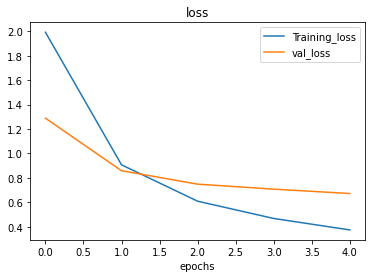

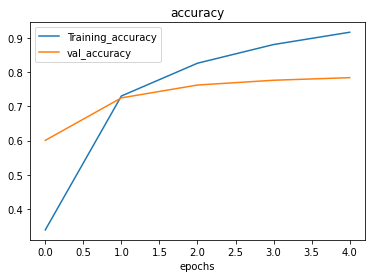

In [26]:
#plot loss curves for resnet model
plot_loss_curves(resnet_history)

###Creating and testing  Efficient Net Tensorflow hub feature extraction model 

In [27]:
from matplotlib import test
#Create efficient netB0 model
efficientnet_model = create_model(model_url=efficientnet_url,
                             num_classes = train_data_10_percent.num_classes)

#Compile Efficientnet model
efficientnet_model.compile(loss = "categorical_crossentropy",
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

EPOCHS = 5

#Fit the Efficientnet model on 10% training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs = EPOCHS,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data = test_data_10_percent,
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="efficientnetb0")]
                                  )
                                        

Saving Tensorboard log files to :tensorflow_hub/efficientnetb0/20230114-014559
Epoch 1/5
24/24 [==============================] - 27s 720ms/step - loss: 1.8450 - accuracy: 0.4480 - val_loss: 1.2799 - val_accuracy: 0.7288
Epoch 2/5
24/24 [==============================] - 15s 647ms/step - loss: 1.0537 - accuracy: 0.7680 - val_loss: 0.8542 - val_accuracy: 0.8200
Epoch 3/5
24/24 [==============================] - 17s 723ms/step - loss: 0.7564 - accuracy: 0.8253 - val_loss: 0.6873 - val_accuracy: 0.8408
Epoch 4/5
24/24 [==============================] - 15s 650ms/step - loss: 0.6070 - accuracy: 0.8520 - val_loss: 0.6032 - val_accuracy: 0.8544
Epoch 5/5
24/24 [==============================] - 15s 648ms/step - loss: 0.5122 - accuracy: 0.8853 - val_loss: 0.5522 - val_accuracy: 0.8620


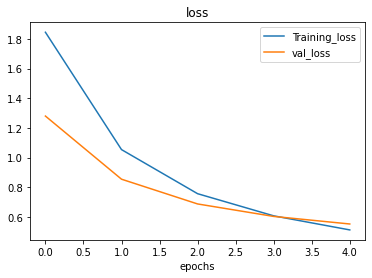

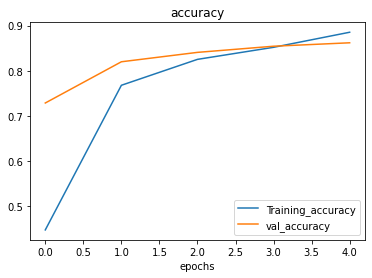

In [28]:
#Plot loss curves
plot_loss_curves(efficientnet_history)

In [29]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [30]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [31]:
#How many layers does efficientnet feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

1. "As in" transfer learning - using an existing model with no changes what so ever (eg. using ImageNet model on 1000 ImageNet classes,none of your own.)
2. "Feature Extraction" transfer learning - use the prelearned patterns of an existing model(eg. EfficientnetB0 trained on ImageNet) and adjust the output layer for your own problem(eg. 1000 classes -> 10 classes of food
3. "Fine Tuning" transfer learning - use the pretrained patterns of an existing model and fine tune many or all of the underlyinh layers(including new output layer)                                                                                                                                                                                    

## Comparing our models results using TensorBoard

Things uploaded to Tensorboard.dev is public.

In [32]:
#Upload Tensorboard Dev records.
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetb0 vs. ResNet50V2" \
  --description "  Comparing two different TF Hub Feature extraction model architectures using 10% of training dat" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=R1xRctAi1gnuXBakv31XDdhYFL9IIs&prompt=consent&access_type=off

TensorBoard experiments published publically using : https://tensorboard.dev/experiment/lhYR6atVTDOlBpYq0pEDsA/

In [33]:
#Check out what tensorboard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/lhYR6atVTDOlBpYq0pEDsA/
	Name                 EfficientNetb0 vs. ResNet50V2
	Description            Comparing two different TF Hub Feature extraction model architectures using 10% of training dat
	Id                   lhYR6atVTDOlBpYq0pEDsA
	Created              2023-01-14 02:04:24 (2 minutes ago)
	Updated              2023-01-14 02:04:29 (2 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918466
Total: 1 experiment(s)


Delete an experiment


!tensorboard dev delete --experiment_id lhYR6atVTDOlBpYq0pEDsA